## Initial steps
1. File -> New -> Terminal
2. In the terminal, type following commands
        mkdir med264/
        cd med264/
        wget https://archive.physionet.org/users/shared/challenge-2019/training_setB.zip
        unzip training_setB.zip

## Load Dependencies

In [4]:
# If needed, install packages (install.packages())
library(tidyverse)
library(data.table)
library(h2o)


Attaching package: ‘data.table’


The following objects are masked from ‘package:h2o’:

    hour, month, week, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Data processing
1. Load the list of files in the input directory
2. Split the records to training and testing set
3. Convert the data into a numpy array

In [11]:
# Name of the input directory
input_directory = 'training_setB'

# Read all PSV files in the input directory and convert to a tibble
all_data <- list.files(path = input_directory, full.names = TRUE) %>% 
    map(., fread, sep = "|") %>% 
    bind_rows() %>% 
    mutate(ID = row_number()) %>%
    as_tibble()


# Split the data into training and testing set
# 80% of data -> Training
# 20% of data -> Testing

train_all  <- slice_sample(all_data, prop = 0.8)

test_all  <- all_data %>%
    anti_join(train_all, by="ID")

train_labels  <- train_all["SepsisLabel"]
test_labels  <- test_all["SepsisLabel"]

train_data <- select(train_all, -c("SepsisLabel", "ID"))
test_data <- select(test_all, -c("SepsisLabel", "ID"))

## Standardization of data
1. Compute the mean and standard deviation of ONLY training set
2. Use the statistics computed to standardize Training and Testing sets

In [12]:
x_mean  <- colMeans(train_data, na.rm = TRUE)
x_sd  <- apply(train_data, 2, sd, na.rm = TRUE)

# For NaN entries, replace with 0
# For the remaining entries, standardize with mean and std
train_data <- sweep(train_data, 2, x_mean, "-") %>%
    sweep(., 2, x_sd, "/")  %>%
    `[<-`(., is.na(.), value = 0) %>% 
    cbind(train_labels)

test_data <- sweep(test_data, 2, x_mean, "-") %>%
    sweep(., 2, x_sd, "/") %>% 
    `[<-`(., is.na(.), value = 0) %>% 
    cbind(test_labels)
    

## Model training
1. We will use a simple logistic regression model to model the data

### Exercise 1
1. Use a different alpha for Logistic Regression (LR) and plot the AUC curves
2. Use a Support Vector Machine classifier instead of LR and plot the AUC curves
   
   https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/svm.html



3. Use a Random Forest Classifier instead of LR and plot the AUC curves 

    https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html

In [13]:
h2o.init()
train_data <- as.h2o(train_data)
test_data <- as.h2o(test_data)

model <- h2o.glm(
    training_frame = train_data,
    y = "SepsisLabel",
    family = 'binomial',
    solver = 'L_BFGS',
    max_iterations = 150,
    alpha = 0, # Alpha=0 corresponds to Ridge Regression (L2) 
    lambda = 1
)


 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 hours 13 minutes 
    H2O cluster timezone:       America/Los_Angeles 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.1.2 
    H2O cluster version age:    7 days, 7 hours and 44 minutes  
    H2O cluster name:           H2O_started_from_R_aaron_dcd137 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.19 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 

  |======================================================================| 100%
  |======================================

## Model prediction
1. Use the trained model to get output probability scores

In [14]:
train_pred_score <- h2o.predict(model, train_data)
test_pred_score <- h2o.predict(model, test_data)


  |======================================================================| 100%
  |======================================================================| 100%


## Performance Metrics
1. Compute Area Under the Curve

In [18]:
train_perf <- h2o.performance(model, train_data)
test_perf <- h2o.performance(model, test_data)

# Compute AUC of training set
train_auc <- h2o.auc(train_perf)

# Compute AUC of testing set
test_auc <- h2o.auc(test_perf)

## Plot AUC curves

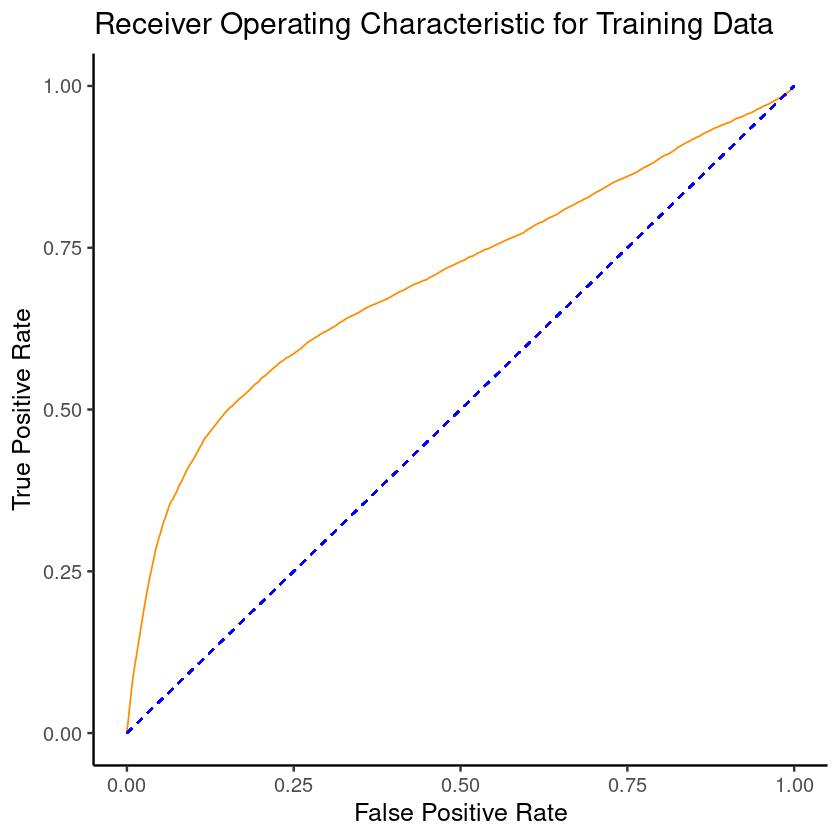

In [19]:
# Train
train_perf@metrics$thresholds_and_metric_scores %>% 
    ggplot(aes(x = fpr, y = tpr)) +
    geom_line(color='darkorange') +
    geom_segment(
        linetype = 'dashed', 
        color = 'blue',
        aes(x = 0, y = 0, xend = 1, yend = 1)
    ) +
    ggtitle("Receiver Operating Characteristic for Training Data") +
    xlab("False Positive Rate") +
    ylab("True Positive Rate") +
    theme_classic(base_size = 15)



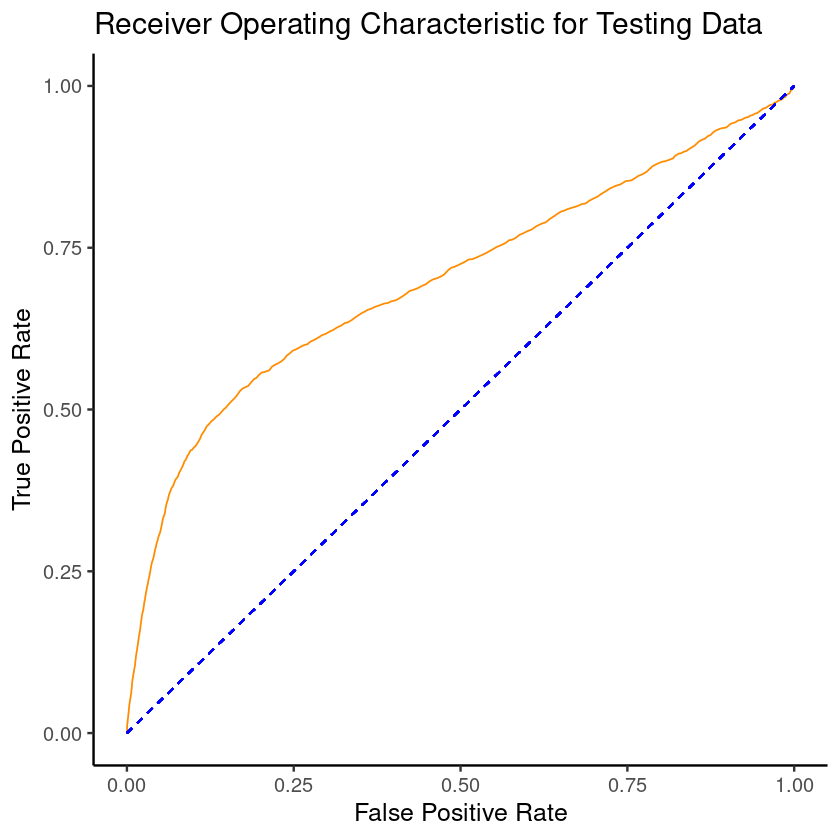

In [20]:
# Test
test_perf@metrics$thresholds_and_metric_scores %>% 
    ggplot(aes(x = fpr, y = tpr)) +
    geom_line(color='darkorange') +
    geom_segment(
        linetype = 'dashed', 
        color = 'blue',
        aes(x = 0, y = 0, xend = 1, yend = 1)
    ) +
    ggtitle("Receiver Operating Characteristic for Testing Data") +
    xlab("False Positive Rate") +
    ylab("True Positive Rate") +
    theme_classic(base_size = 15)


## Exercise 2 - Interpretability

Methods such as LIME [1], SHAP [2] allow for revealing the top features contributing to the predicted score at a local level. 

The h2o library uses the method of shapley values to determine the top contributing features.

Use the h2o library to show the partial dependance plots and summary plot for each of the models developed above.

Some examples using SHAP: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html

[1] https://christophm.github.io/interpretable-ml-book/lime.html

[2] https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d